# Helper code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
folder_path = '/content/drive/My Drive/Jun_26_output'
if os.path.exists(folder_path):
  print(f"Folder '{folder_path}' exists. You can now access its contents.")
  # Example: list files in the folder
  for filename in os.listdir(folder_path):
    print(filename)
else:
  print(f"Folder '{folder_path}' not found. Please check the path and ensure it exists in your Google Drive.")

Folder '/content/drive/My Drive/Jun_26_output' exists. You can now access its contents.
runs
checkpoint-250
adapter_model.safetensors
adapter_config.json
chat_template.jinja
tokenizer_config.json
special_tokens_map.json
tokenizer.json
training_args.bin
value_model
README.md


In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

In [ ]:
import torch
from peft import PeftModel, PeftConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
base_model_id = "cleanrl/EleutherAI_pythia-1b-deduped__sft__tldr"
adapter_id = "/content/drive/My Drive/Jun_26_output"
value_model_id = "/content/drive/My Drive/Jun_26_output/value_model"
reward_model_id = "cleanrl/EleutherAI_pythia-1b-deduped__reward__tldr"

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

In [ ]:
# Method 1: Load using PeftModel (Recommended)
print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map=device,
)

print("Loading PEFT adapter...")
model = PeftModel.from_pretrained(base_model, adapter_id)

Loading base model...
Loading PEFT adapter...


In [ ]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(50304, 2048)
        (emb_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-15): 16 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (post_attention_dropout): Dropout(p=0.0, inplace=False)
            (post_mlp_dropout): Dropout(p=0.0, inplace=False)
            (attention): GPTNeoXAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=6144, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=Fa

In [ ]:
def generate_text(prompt, max_length=52):
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    input_length = inputs["input_ids"].shape[1]

    with torch.no_grad():
        outputs = base_model.generate(
            **inputs,
            # max_length=max_length,
            max_new_tokens=max_length,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Remove the prompt tokens from the generated output
    generated_text = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)
    return generated_text

In [ ]:
prompt = """SUBREDDIT: r/AskReddit

TITLE: I just found out that I am being accused of academic dishonesty. What do I do?

POST: In my Japanese 1002 class we are required to record ourselves doing drills - repeating after audio files, etc....I got an email over the weekend from my professor asking me to come talk to her my most recent submission on Monday. I, being a total fucking idiot, completely forgot to do so. She just sent me another email letting me know that she and her colleagues think that I have violated the code of academic honesty.

I responded to her e-mail immediately apologizing profusely for not coming to see her and letting her know that if I have done something wrong it was due to ignorance on my part rather than dishonest intentions. Now I'm waiting to hear back from her.

I am not sure how I could have cheated - I did my last recording very early in the morning and it is possible I made some sort of error due to sleep deprivation. Maybe I didn't record the time it took me to do it properly or something like that. I'm freaking out right now thinking that perhaps I did something terribly wrong without realizing it and will have academic dishonesty charges on my record forever.

TL;DR:"""

In [ ]:
response = generate_text(prompt)
print(response)

 My professor thinks I have committed academic dishonesty, how do I clear my record?

TL;DR: I have done an audio recording and not recorded the time it took me to do it properly/etc. what are my options?

EDIT


In [ ]:
value_model =  AutoModelForSequenceClassification.from_pretrained(value_model_id)

In [ ]:
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model_id, num_labels=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

In [ ]:
reward_tokenizer = AutoTokenizer.from_pretrained(reward_model_id)
if reward_tokenizer.pad_token is None:
    reward_tokenizer.pad_token = reward_tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
reward_model

GPTNeoXForSequenceClassification(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((2048,

In [ ]:
max_reward_len = reward_model.config.max_position_embeddings
max_reward_len

NameError: name 'reward_model' is not defined

#### reward model

In [ ]:
def score_response(prompt, response):
    inputs = reward_tokenizer(prompt, response, return_tensors="pt", truncation=True, max_length=max_reward_len)
    print("inputs shape", type(inputs))
    reward = reward_model(**inputs).logits.item()
    return reward

In [ ]:
reward = score_response(prompt, response)

inputs shape <class 'transformers.tokenization_utils_base.BatchEncoding'>


In [ ]:
def score_response_for_each_token(prompt, response):
    rewards = []
    for i in range(len(response)):
        inputs = reward_tokenizer(prompt, response[:i], return_tensors="pt", truncation=True, max_length=max_reward_len)
        reward = reward_model(**inputs).logits.item()
        rewards.append(reward)
    return rewards

In [ ]:
max_value_len = value_model.config.max_position_embeddings
max_value_len

2048

In [ ]:
reward_tokenizer

GPTNeoXTokenizerFast(name_or_path='cleanrl/EleutherAI_pythia-1b-deduped__reward__tldr', vocab_size=50254, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|padding|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50254: AddedToken("                        ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50255: AddedToken("                       ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50256: AddedToken("                      ", rstrip=False, lstrip=False, single_word=False, normalized=True, spec

In [ ]:
tokenizer

GPTNeoXTokenizerFast(name_or_path='cleanrl/EleutherAI_pythia-1b-deduped__sft__tldr', vocab_size=50254, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|padding|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50254: AddedToken("                        ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50255: AddedToken("                       ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50256: AddedToken("                      ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),

In [ ]:
def estimated_value(prompt, response):
    inputs = tokenizer(prompt,response,  return_tensors="pt", truncation=True, max_length=max_value_len)
    value = value_model(**inputs).logits.item()
    return value

In [ ]:
pred_value = estimated_value(prompt, response)

In [ ]:
pred_value

31.892797470092773

In [ ]:
rewards_tokenwise = score_response_for_each_token(prompt, response)

AttributeError: 'list' object has no attribute 'sum'

In [ ]:
true_value = rewards_tokenwise.sum()


In [ ]:
from datasets import load_dataset

In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
source = "trl-internal-testing/tldr-preference-sft-trl-style"
test_data = load_dataset(source, split="test", download_mode="force_redownload")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/780 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/159M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/160M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116722 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6447 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6553 [00:00<?, ? examples/s]

In [ ]:
# prompt: select 100 samples from the test_data

test_data_samples = test_data.select(range(100))

In [ ]:
test_data_samples

Dataset({
    features: ['prompt', 'messages', 'id', 'subreddit', 'title', 'post', 'summary'],
    num_rows: 100
})

In [ ]:
import pandas as pd
# temp = pd.DataFrame(columns=['prompt', 'response'])

In [ ]:
# Create an empty list to store the new rows
new_rows = []

for i in test_data_samples:
  prompt = i['prompt']
  response = generate_text(prompt)
  # Append the new row as a dictionary to the list
  new_rows.append({'prompt': prompt, 'response': response})

# Concatenate the list of new rows to the DataFrame
temp = pd.concat([temp, pd.DataFrame(new_rows)], ignore_index=True)

In [ ]:
temp.to_csv("samples_text_generations.csv")

In [ ]:
# Set pad_token_id if missing
if reward_tokenizer.pad_token is None:
    reward_tokenizer.pad_token = reward_tokenizer.eos_token

reward_model.config.pad_token_id = reward_tokenizer.pad_token_id


In [ ]:
temp = pd.read_csv("samples_text_generations.csv")

In [ ]:
def score_response_for_each_token_batched(prompt, response, batch_size=8):
    input_texts = [prompt + response[:i] for i in range(1, len(response)+1)]
    rewards = []

    for i in range(0, len(input_texts), batch_size):
        batch = input_texts[i:i+batch_size]
        inputs = reward_tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=2048)
        inputs = {k: v.to(reward_model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = reward_model(**inputs)
            logits = outputs.logits.squeeze(-1)  # shape: [batch_size]

        rewards.extend(logits.tolist())

    return rewards


In [ ]:
temp['token_rewards'] = temp.apply(lambda row: score_response_for_each_token_batched(row['prompt'], row['response']), axis=1)
display(temp.head())

In [ ]:
temp = pd.read_csv("scored_output.csv")

In [ ]:
temp['pred_value'] = temp.apply(lambda row: estimated_value(row['prompt'], row['response']), axis=1)
display(temp.head())

,Unnamed: 0,prompt,response,reward_last_token,reward_total,pred_value
0,0,SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...,I'm having a lot of trouble not thinking of g...,-1.248170,-591.672936,31.420921
1,1,SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...,"SONS KID DIED TONIGHT, SO DO NOT GIVE TO FEED...",3.555269,27.660521,32.012291
2,2,SUBREDDIT: r/relationships\n\nTITLE: The girl ...,Girl I'm seeing has terrible service when out...,-0.447317,-353.721942,33.173790
3,3,SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...,"Asked Grandma to walk out, her nose was black...",1.567161,-92.185068,31.881323
4,4,SUBREDDIT: r/relationships\n\nTITLE: I [32 M] ...,Found out a year from now after 18 months tha...,1.937319,-148.702378,32.867588


In [20]:
def get_squared_value_error(pred_value, true_value):
  return (pred_value - true_value)**2

In [ ]:
temp['value_error'] = temp.apply(lambda row: get_squared_value_error(row['pred_value'], row['reward_total']), axis=1)
display(temp.head())

,Unnamed: 0,prompt,response,reward_last_token,reward_total,pred_value,value_error
0,0,SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...,I'm having a lot of trouble not thinking of g...,-1.248170,-591.672936,31.420921,388245.954684
1,1,SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...,"SONS KID DIED TONIGHT, SO DO NOT GIVE TO FEED...",3.555269,27.660521,32.012291,18.937901
2,2,SUBREDDIT: r/relationships\n\nTITLE: The girl ...,Girl I'm seeing has terrible service when out...,-0.447317,-353.721942,33.173790,149688.307114
3,3,SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...,"Asked Grandma to walk out, her nose was black...",1.567161,-92.185068,31.881323,15392.469226
4,4,SUBREDDIT: r/relationships\n\nTITLE: I [32 M] ...,Found out a year from now after 18 months tha...,1.937319,-148.702378,32.867588,32967.652573


In [23]:
ç = pd.read_csv("scored_output_with_rewards.csv")

In [ ]:
rewards_array_temp.head()

,Unnamed: 0,prompt,response,reward_last_token,reward_total,rewards
0,0,SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...,I'm having a lot of trouble not thinking of g...,-1.248170,-591.672936,"[-3.4888336658477783, -5.988675594329834, -3.4..."
1,1,SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...,"SONS KID DIED TONIGHT, SO DO NOT GIVE TO FEED...",3.555269,27.660521,"[-2.927161455154419, -5.22538948059082, -3.113..."
2,2,SUBREDDIT: r/relationships\n\nTITLE: The girl ...,Girl I'm seeing has terrible service when out...,-0.447317,-353.721942,"[-3.6025383472442627, -6.050045013427734, 0.41..."
3,3,SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...,"Asked Grandma to walk out, her nose was black...",1.567161,-92.185068,"[-1.8314822912216187, -3.5949456691741943, -2...."
4,4,SUBREDDIT: r/relationships\n\nTITLE: I [32 M] ...,Found out a year from now after 18 months tha...,1.937319,-148.702378,"[-1.7809041738510132, -4.640909194946289, -2.5..."


In [ ]:
temp = temp.merge(rewards_array_temp, on=["prompt", "response", "reward_last_token", "reward_total", "Unnamed: 0" ])
temp.head()

,Unnamed: 0,prompt,response,reward_last_token,reward_total,pred_value,value_error,rewards
0,0,SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...,I'm having a lot of trouble not thinking of g...,-1.248170,-591.672936,31.420921,388245.954684,"[-3.4888336658477783, -5.988675594329834, -3.4..."
1,1,SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...,"SONS KID DIED TONIGHT, SO DO NOT GIVE TO FEED...",3.555269,27.660521,32.012291,18.937901,"[-2.927161455154419, -5.22538948059082, -3.113..."
2,2,SUBREDDIT: r/relationships\n\nTITLE: The girl ...,Girl I'm seeing has terrible service when out...,-0.447317,-353.721942,33.173790,149688.307114,"[-3.6025383472442627, -6.050045013427734, 0.41..."
3,3,SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...,"Asked Grandma to walk out, her nose was black...",1.567161,-92.185068,31.881323,15392.469226,"[-1.8314822912216187, -3.5949456691741943, -2...."
4,4,SUBREDDIT: r/relationships\n\nTITLE: I [32 M] ...,Found out a year from now after 18 months tha...,1.937319,-148.702378,32.867588,32967.652573,"[-1.7809041738510132, -4.640909194946289, -2.5..."


In [31]:
temp.rename(columns={'reward_total': 'true_value'}, inplace=True)
temp.rename(columns={'rewards': 'tokenwise_rewards'}, inplace=True)

In [32]:
temp.head()

,Unnamed: 0,prompt,response,reward_last_token,true_value,pred_value,value_error,tokenwise_rewards
0,0,SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...,I'm having a lot of trouble not thinking of g...,-1.248170,-591.672936,31.420921,388245.954684,"[-3.4888336658477783, -5.988675594329834, -3.4..."
1,1,SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...,"SONS KID DIED TONIGHT, SO DO NOT GIVE TO FEED...",3.555269,27.660521,32.012291,18.937901,"[-2.927161455154419, -5.22538948059082, -3.113..."
2,2,SUBREDDIT: r/relationships\n\nTITLE: The girl ...,Girl I'm seeing has terrible service when out...,-0.447317,-353.721942,33.173790,149688.307114,"[-3.6025383472442627, -6.050045013427734, 0.41..."
3,3,SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...,"Asked Grandma to walk out, her nose was black...",1.567161,-92.185068,31.881323,15392.469226,"[-1.8314822912216187, -3.5949456691741943, -2...."
4,4,SUBREDDIT: r/relationships\n\nTITLE: I [32 M] ...,Found out a year from now after 18 months tha...,1.937319,-148.702378,32.867588,32967.652573,"[-1.7809041738510132, -4.640909194946289, -2.5..."


In [57]:
# Function to compute consecutive sums
def compute_value_per_token(rewards):
    if not rewards:
        return []
    result = [rewards[0]]
    for i in range(1, len(rewards)):
        result.append(rewards[i-1] + rewards[i])
    return result

# Apply the function
temp['tokenwise_value'] = temp['tokenwise_rewards'].apply(compute_value_per_token)

print(temp)

    Unnamed: 0                                             prompt  \
0            0  SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...   
1            1  SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...   
2            2  SUBREDDIT: r/relationships\n\nTITLE: The girl ...   
3            3  SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...   
4            4  SUBREDDIT: r/relationships\n\nTITLE: I [32 M] ...   
..         ...                                                ...   
95          95  SUBREDDIT: r/tifu\n\nTITLE: TIFU by inviting t...   
96          96  SUBREDDIT: r/relationships\n\nTITLE: My GF [25...   
97          97  SUBREDDIT: r/offmychest\n\nTITLE: I am sick an...   
98          98  SUBREDDIT: r/relationships\n\nTITLE: Help, ple...   
99          99  SUBREDDIT: r/relationships\n\nTITLE: (21F) Fou...   

                                             response  reward_last_token  \
0    I'm having a lot of trouble not thinking of g...          -1.248170   
1    SONS KID DIED 

In [45]:
type(temp['tokenwise_value'])

pandas.core.series.Series

In [59]:
def compute_td_error(values):
    return [values[i+1] - values[i] for i in range(len(values) - 1)]

temp['td_error'] = temp['tokenwise_value'].apply(compute_td_error)

In [ ]:
tem

In [53]:
import ast

def get_list_from_string(string):
  list_object = ast.literal_eval(string)
  return list_object

In [54]:
temp['tokenwise_rewards'] = temp['tokenwise_rewards'].apply(get_list_from_string)

# Final analysis

In [60]:
temp

,Unnamed: 0,prompt,response,reward_last_token,true_value,pred_value,value_error,tokenwise_rewards,tokenwise_value,td_error
0,0,SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...,I'm having a lot of trouble not thinking of g...,-1.248170,-591.672936,31.420921,388245.954684,"[-3.4888336658477783, -5.988675594329834, -3.4...","[-3.4888336658477783, -9.477509260177612, -9.4...","[-5.988675594329834, 0.06559371948242188, 4.76..."
1,1,SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...,"SONS KID DIED TONIGHT, SO DO NOT GIVE TO FEED...",3.555269,27.660521,32.012291,18.937901,"[-2.927161455154419, -5.22538948059082, -3.113...","[-2.927161455154419, -8.15255093574524, -8.338...","[-5.22538948059082, -0.18617486953735352, 2.24..."
2,2,SUBREDDIT: r/relationships\n\nTITLE: The girl ...,Girl I'm seeing has terrible service when out...,-0.447317,-353.721942,33.173790,149688.307114,"[-3.6025383472442627, -6.050045013427734, 0.41...","[-3.6025383472442627, -9.652583360671997, -5.6...","[-6.050045013427734, 4.019497603178024, 3.7118..."
3,3,SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...,"Asked Grandma to walk out, her nose was black...",1.567161,-92.185068,31.881323,15392.469226,"[-1.8314822912216187, -3.5949456691741943, -2....","[-1.8314822912216187, -5.426427960395813, -5.6...","[-3.5949456691741943, -0.19684374332427979, 2...."
4,4,SUBREDDIT: r/relationships\n\nTITLE: I [32 M] ...,Found out a year from now after 18 months tha...,1.937319,-148.702378,32.867588,32967.652573,"[-1.7809041738510132, -4.640909194946289, -2.5...","[-1.7809041738510132, -6.421813368797302, -7.2...","[-4.640909194946289, -0.7792900800704956, 1.17..."
...,...,...,...,...,...,...,...,...,...,...
95,95,SUBREDDIT: r/tifu\n\nTITLE: TIFU by inviting t...,In the bush with a bunch of Aboriginal people...,1.193817,-129.349721,31.225309,25784.340361,"[-2.973642110824585, -4.5757575035095215, -1.6...","[-2.973642110824585, -7.5493996143341064, -6.2...","[-4.5757575035095215, 1.3439154624938965, 4.79..."
96,96,SUBREDDIT: r/relationships\n\nTITLE: My GF [25...,my GF moved out of her current apartment and ...,2.420581,-367.407350,33.410580,160655.012844,"[-2.7294652462005615, -6.36242151260376, -2.60...","[-2.7294652462005615, -9.091886758804321, -8.9...","[-6.36242151260376, 0.1253187656402588, 3.1623..."
97,97,SUBREDDIT: r/offmychest\n\nTITLE: I am sick an...,My friend has been dealing with severe depres...,3.677967,-90.110586,30.880409,14638.820998,"[-3.9821810722351074, -6.406269073486328, -1.3...","[-3.9821810722351074, -10.388450145721436, -7....","[-6.406269073486328, 2.6499370336532593, 3.639..."
98,98,"SUBREDDIT: r/relationships\n\nTITLE: Help, ple...",wedding photographer doesn't really show my w...,4.065956,-204.209412,31.721626,55663.454903,"[-3.375133752822876, -6.1266069412231445, -3.2...","[-3.375133752822876, -9.50174069404602, -9.393...","[-6.1266069412231445, 0.10782003402709961, 2.0..."


In [61]:
temp.to_csv("everything.csv")

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Value error

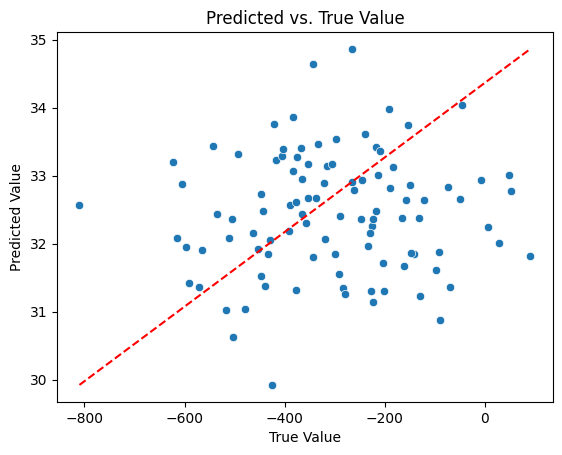

In [ ]:
sns.scatterplot(data=temp, x='true_value', y='pred_value')
plt.title("Predicted vs. True Value")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.plot([temp['true_value'].min(), temp['true_value'].max()],
         [temp['pred_value'].min(), temp['pred_value'].max()], 'r--')  # identity line
plt.show()


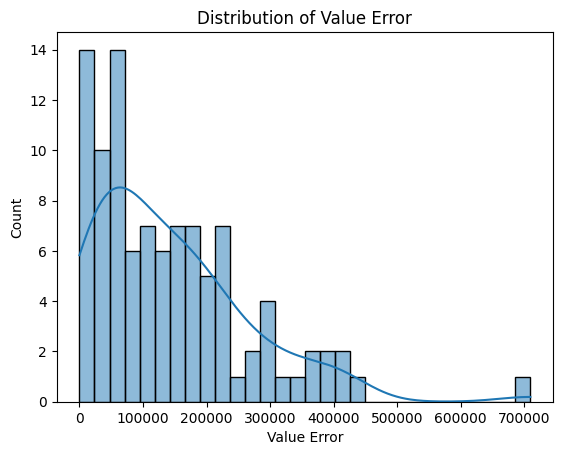

In [69]:
sns.histplot(temp['value_error'], bins=30, kde=True)
plt.title("Distribution of Value Error")
plt.xlabel("Value Error")
plt.show()

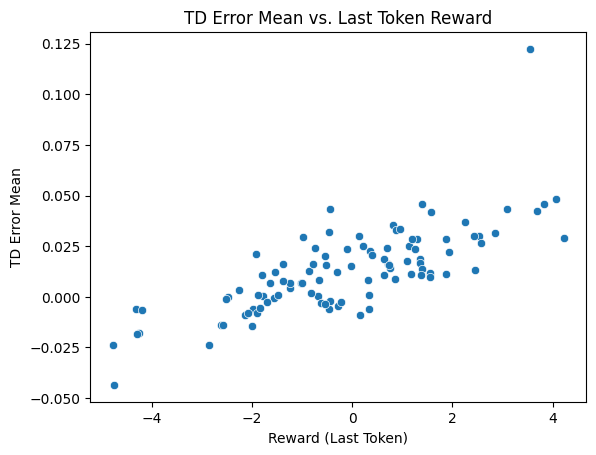

In [74]:
temp['td_error_mean'] = temp['td_error'].apply(lambda x: np.mean(x) if x else np.nan)
sns.scatterplot(data=temp, x='reward_last_token', y='td_error_mean')
plt.title("TD Error Mean vs. Last Token Reward")
plt.xlabel("Reward (Last Token)")
plt.ylabel("TD Error Mean")
plt.show()


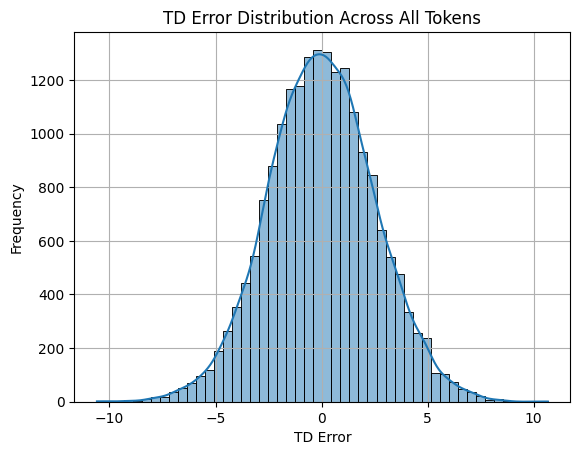

In [77]:
# Flatten all TD error arrays into one list
flat_td_errors = [err for row in temp['td_error'] for err in row]

# Plot histogram with KDE (Kernel Density Estimation)
sns.histplot(flat_td_errors, bins=50, kde=True)
plt.title("TD Error Distribution Across All Tokens")
plt.xlabel("TD Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Reward vs Value Error')

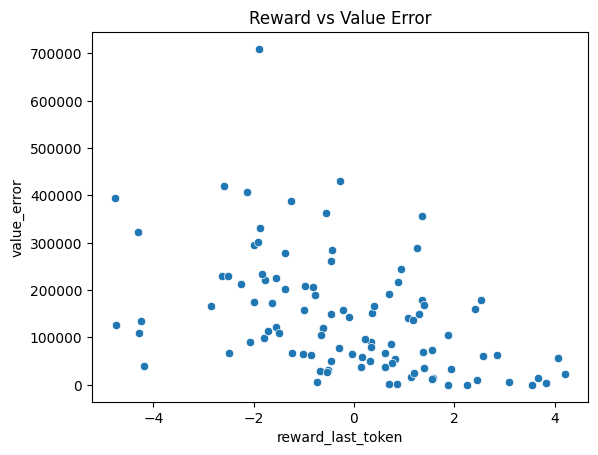

In [80]:
sns.scatterplot(data=temp, x='reward_last_token', y='value_error')
plt.title("Reward vs Value Error")

Text(0.5, 1.0, 'TD Error Std vs Value Error')

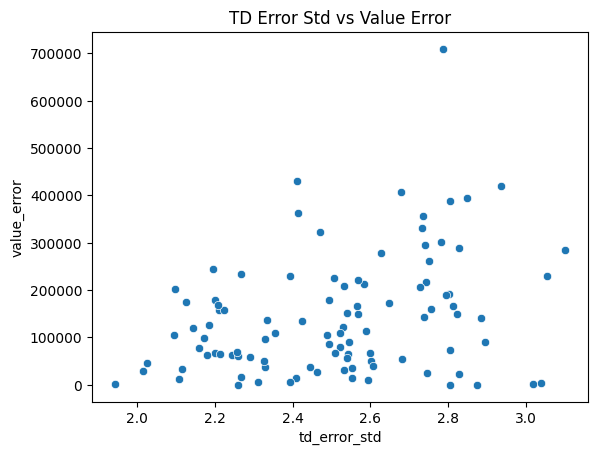

In [83]:
temp['td_error_std'] = temp['td_error'].apply(lambda x: np.std(x) if x else np.nan)
sns.scatterplot(data=temp, x='td_error_std', y='value_error')
plt.title("TD Error Std vs Value Error")

Text(0.5, 1.0, 'Sequence Length vs Value Error')

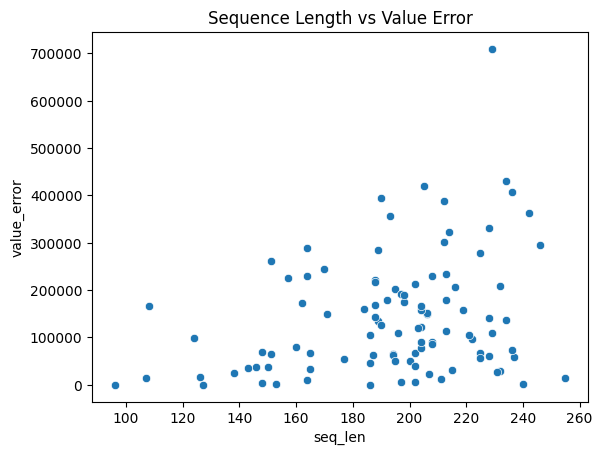

In [84]:
temp['seq_len'] = temp['td_error'].apply(len)
sns.scatterplot(data=temp, x='seq_len', y='value_error')
plt.title("Sequence Length vs Value Error")

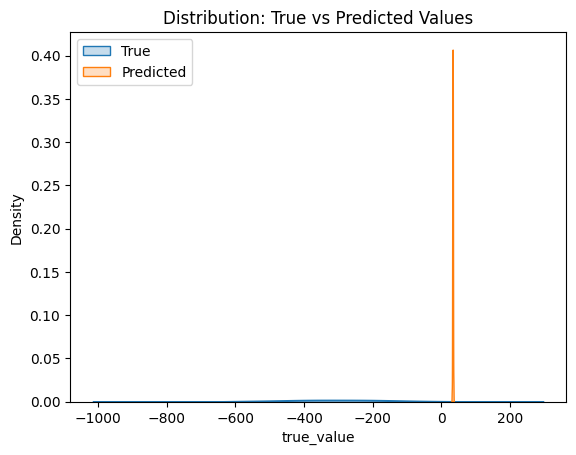

In [ ]:
sns.kdeplot(temp['true_value'], label='True', shade=True)
sns.kdeplot(temp['pred_value'], label='Predicted', shade=True)
plt.title("Distribution: True vs Predicted Values")
plt.legend()

Text(0.5, 1.0, 'Autocorrelation of TD Error (Example Sequence)')

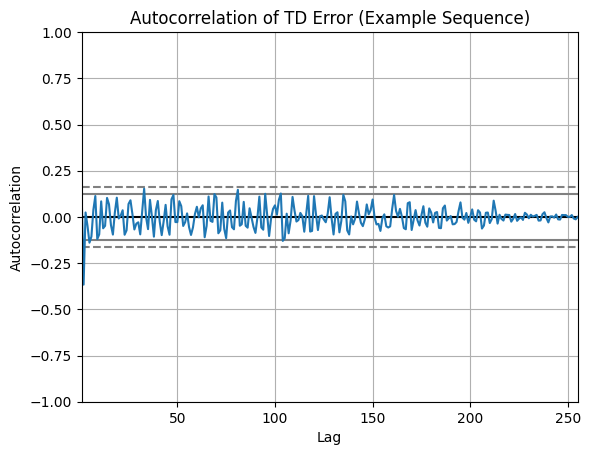

In [87]:
# Use a long sequence for demonstration
long_td = max(temp['td_error'], key=len)
pd.plotting.autocorrelation_plot(pd.Series(long_td))
plt.title("Autocorrelation of TD Error (Example Sequence)")


Text(0.5, 1.0, 'Value Error Distribution')

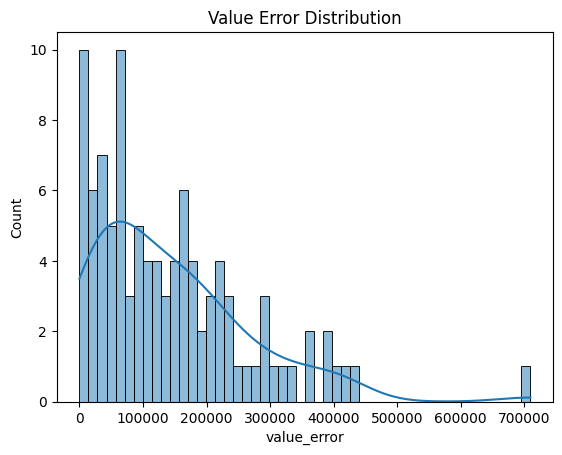

In [ ]:
sns.histplot(temp['value_error'], bins=50, kde=True)
plt.title("Value Error Distribution")

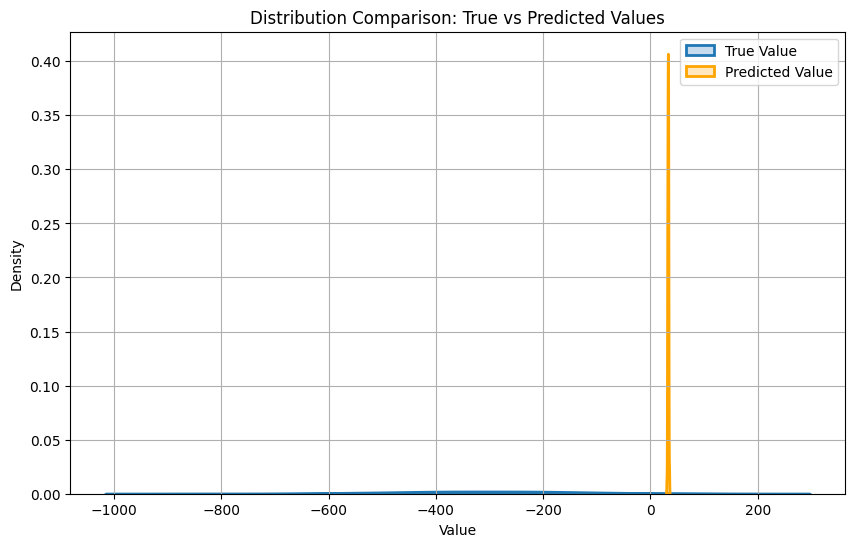

In [89]:

plt.figure(figsize=(10, 6)
sns.kdeplot(temp['true_value'], label='True Value', fill=True, linewidth=2)
sns.kdeplot(temp['pred_value'], label='Predicted Value', fill=True, linewidth=2, color='orange')

plt.title("Distribution Comparison: True vs Predicted Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


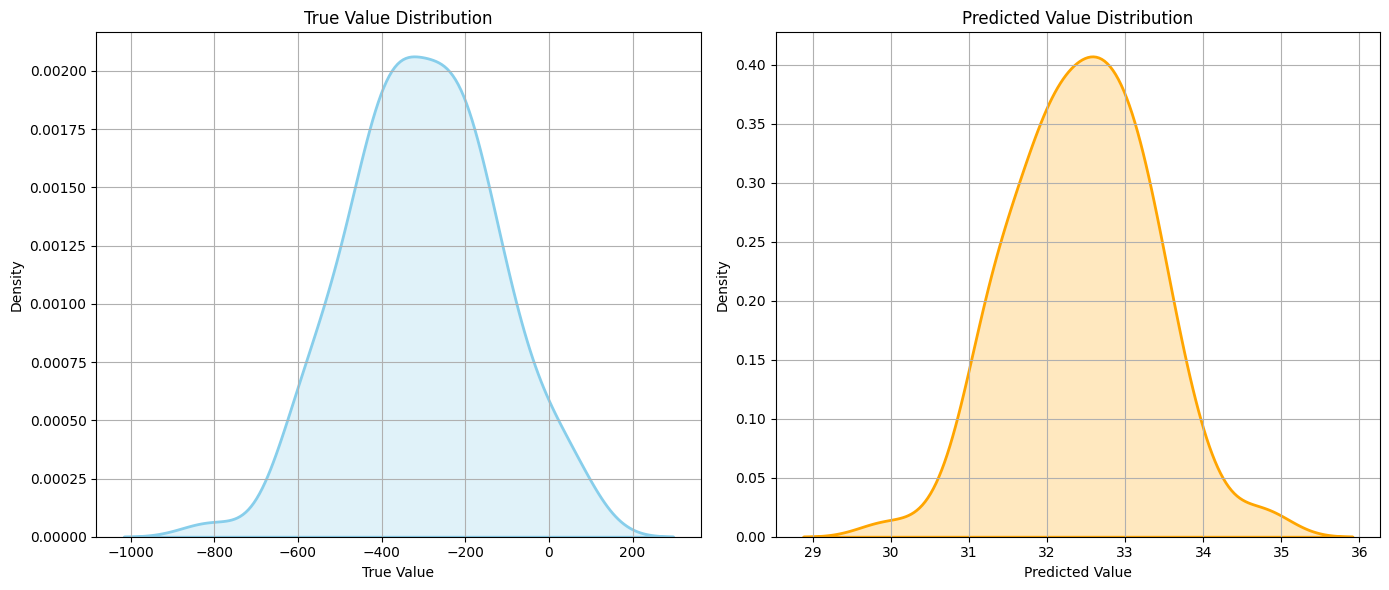

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot True Value Distribution
sns.kdeplot(temp['true_value'], ax=axes[0], fill=True, linewidth=2, color='skyblue')
axes[0].set_title("True Value Distribution")
axes[0].set_xlabel("True Value")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Predicted Value Distribution
sns.kdeplot(temp['pred_value'], ax=axes[1], fill=True, linewidth=2, color='orange')
axes[1].set_title("Predicted Value Distribution")
axes[1].set_xlabel("Predicted Value")
axes[1].set_ylabel("Density")
axes[1].grid(True)

plt.tight_layout()
plt.show()


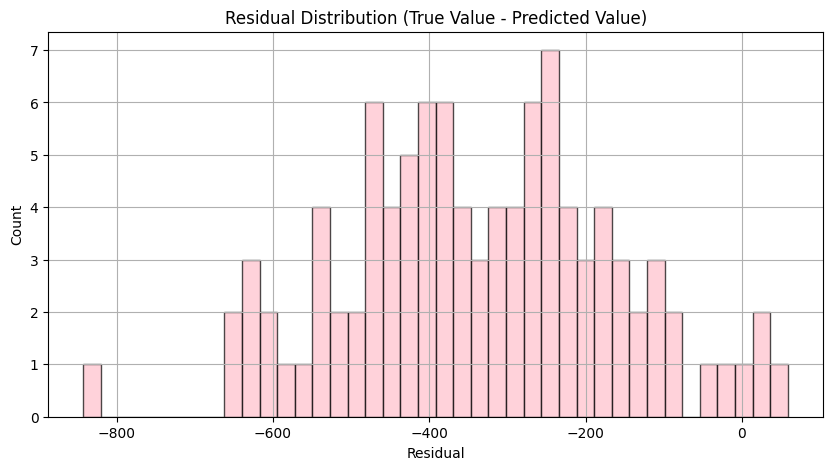

In [ ]:
# Calculate residuals
temp['residual'] = temp['true_value'] - temp['pred_value']

# Plot residuals
plt.figure(figsize=(10, 5))
plt.hist(temp['residual'], bins=40, color='pink', edgecolor='black', alpha=0.7)
plt.title("Residual Distribution (True Value - Predicted Value)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
true = temp['true_value']
pred = temp['pred_value']

mse = mean_squared_error(true, pred)
mae = mean_absolute_error(true, pred)
r2 = r2_score(true, pred)

print(f"Mean Squared Error (MSE):     {mse:.4f}")
print(f"Mean Absolute Error (MAE):    {mae:.4f}")
print(f"R-squared (R²):               {r2:.4f}")


Mean Squared Error (MSE):     142538.2654
Mean Absolute Error (MAE):    337.9965
R-squared (R²):               -3.8223


## TD Error

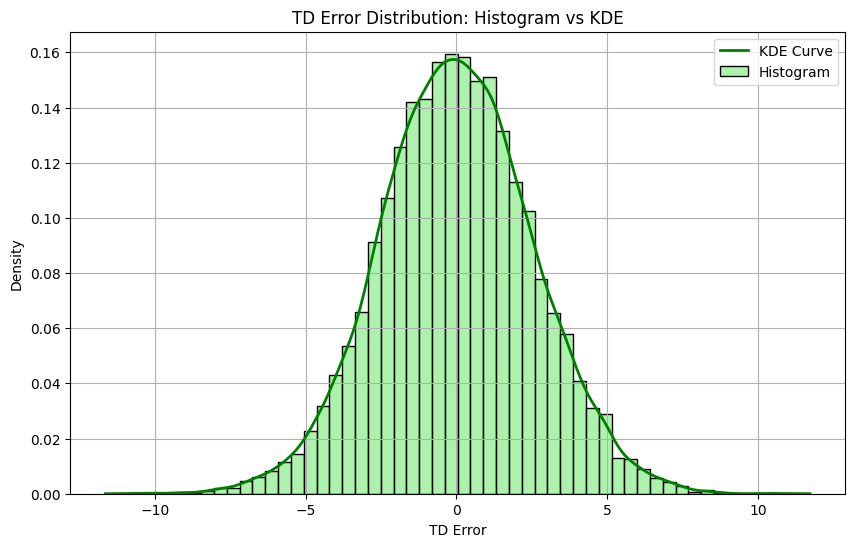

In [107]:
# Flatten TD errors
flat_td_errors = [err for row in temp['td_error'] for err in row]

plt.figure(figsize=(10, 6))

# Histogram in one color
sns.histplot(flat_td_errors, bins=50, stat='density', color='lightgreen', label='Histogram')

# KDE curve in a different color
sns.kdeplot(flat_td_errors, color='green', linewidth=2, label='KDE Curve')

plt.title("TD Error Distribution: Histogram vs KDE")
plt.xlabel("TD Error")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


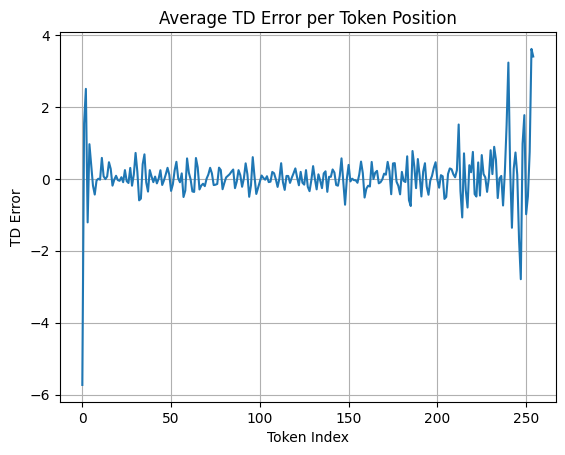

In [110]:
# Pad TD error sequences
max_len = max(len(x) for x in temp['td_error'])
td_matrix = np.array([
    np.pad(x, (0, max_len - len(x)), constant_values=np.nan)
    for x in temp['td_error']
])

mean_td = np.nanmean(td_matrix, axis=0)

plt.plot(mean_td)
plt.title("Average TD Error per Token Position")
plt.xlabel("Token Index")
plt.ylabel("TD Error")
plt.grid(True)
plt.show()


In [112]:
temp['td_error_abs_mean'] = temp['td_error'].apply(lambda x: np.mean(np.abs(x)))

Text(0.5, 1.0, 'Distribution of Mean Absolute TD Error per Example')

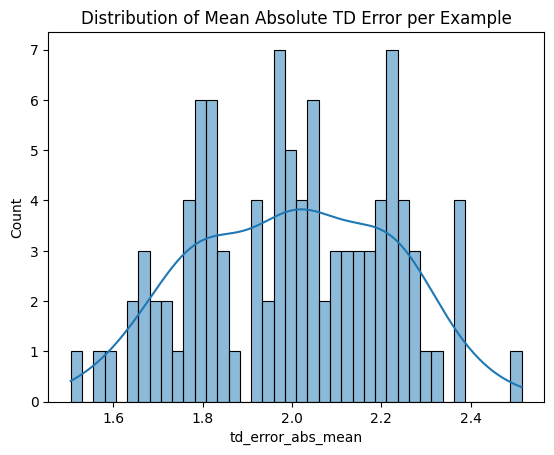

In [114]:
sns.histplot(temp['td_error_abs_mean'], bins=40, kde=True)
plt.title("Distribution of Mean Absolute TD Error per Example")

Text(0.5, 1.0, 'Mean TD Error vs Value Error')

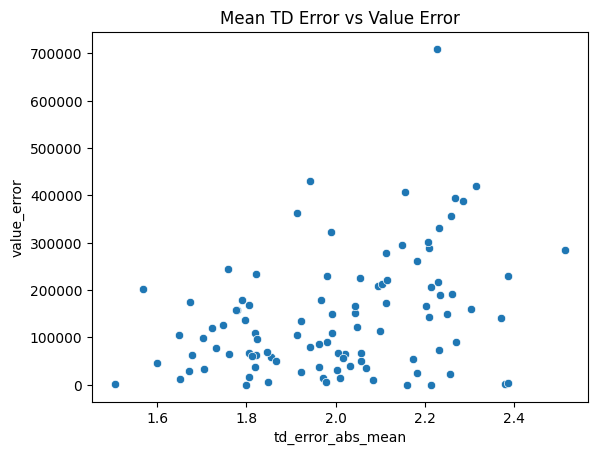

In [116]:
sns.scatterplot(data=temp, x='td_error_abs_mean', y='value_error')
plt.title("Mean TD Error vs Value Error")

<Axes: xlabel='response_len', ylabel='reward_last_token'>

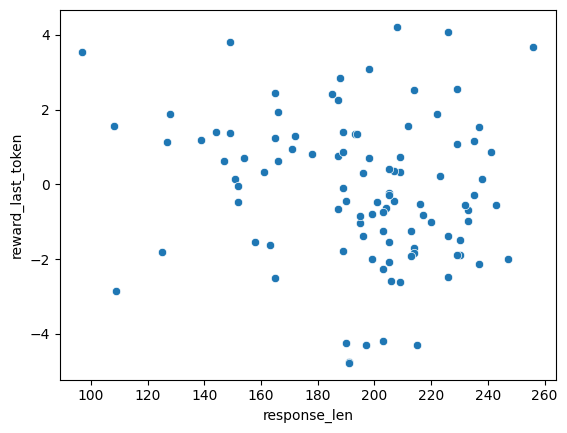

In [117]:
temp['response_len'] = temp['response'].str.len()
sns.scatterplot(data=temp, x='response_len', y='reward_last_token')

Text(0.5, 1.0, 'Calibration Curve: Predicted vs Actual Value')

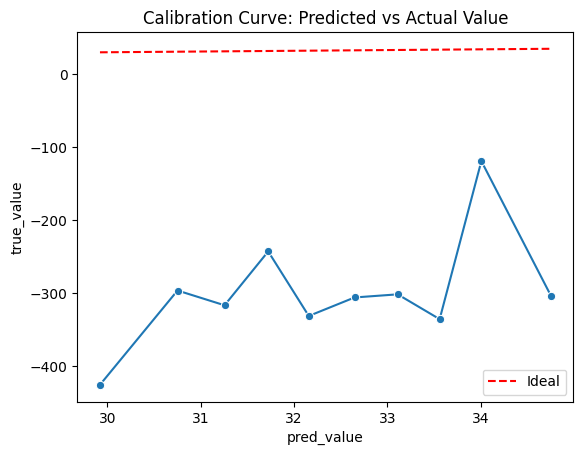

In [ ]:
temp['value_bin'] = pd.cut(temp['pred_value'], bins=10)
calib = temp.groupby('value_bin')[['pred_value', 'true_value']].mean().reset_index()

sns.lineplot(data=calib, x='pred_value', y='true_value', marker='o')
plt.plot(calib['pred_value'], calib['pred_value'], 'r--', label='Ideal')
plt.legend()
plt.title("Calibration Curve: Predicted vs Actual Value")

Text(0.5, 1.0, 'Predicted Value vs Cumulative Reward (Example 0)')

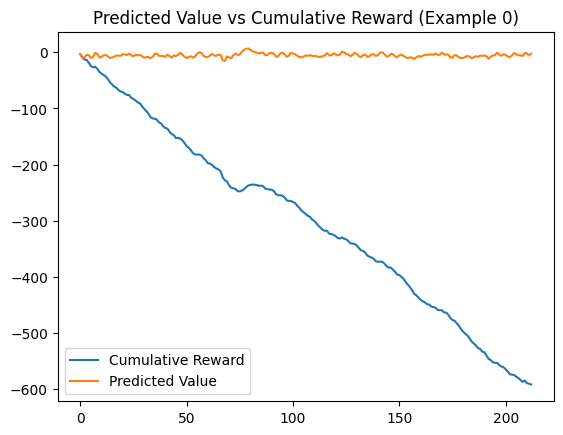

In [119]:
i = 0  # select a sample
plt.plot(np.cumsum(temp['tokenwise_rewards'].iloc[i]), label='Cumulative Reward')
plt.plot(temp['tokenwise_value'].iloc[i], label='Predicted Value')
plt.legend()
plt.title("Predicted Value vs Cumulative Reward (Example {})".format(i))

Text(0.5, 1.0, 'Residual Bias (Predicted - True) vs True Value')

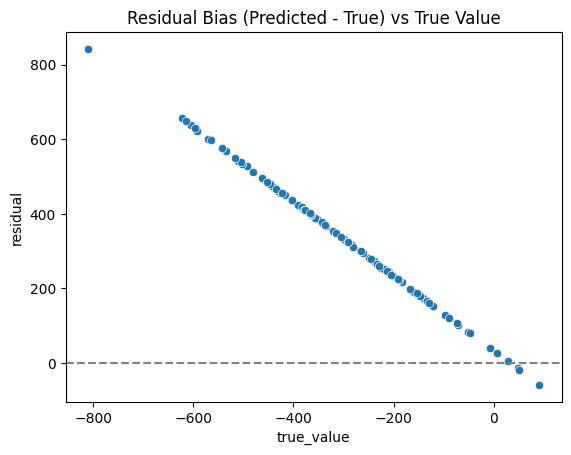

In [ ]:
temp['residual'] = temp['pred_value'] - temp['true_value']
sns.scatterplot(data=temp, x='true_value', y='residual')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residual Bias (Predicted - True) vs True Value")